In [29]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #splits data for training and testing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [30]:
file_path = 'Medicinal Leaf dataset'

In [31]:
name_class = os.listdir(file_path)
name_class

['Aloevera',
 'Amla',
 'Amruthaballi',
 'Arali',
 'ashoka',
 'Astma_weed',
 'Badipala',
 'Balloon_Vine',
 'Bamboo',
 'Beans',
 'Betel',
 'Bhrami',
 'Bringaraja',
 'camphor',
 'Caricature',
 'Castor',
 'Catharanthus',
 'Chakte',
 'Chilly',
 'Citron lime (herelikai)',
 'Coffee',
 'Common rue(naagdalli)',
 'Coriender',
 'Curry',
 'Doddpathre',
 'Drumstick',
 'Ekka',
 'Eucalyptus',
 'Ganigale',
 'Ganike',
 'Gasagase',
 'Ginger',
 'Globe Amarnath',
 'Guava',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jackfruit',
 'Jasmine',
 'kamakasturi',
 'Kambajala',
 'Kasambruga',
 'kepala',
 'Kohlrabi',
 'Lantana',
 'Lemon',
 'Lemongrass',
 'Malabar_Nut',
 'Malabar_Spinach',
 'Mango',
 'Marigold',
 'Mint',
 'Neem',
 'Nelavembu',
 'Nerale',
 'Nooni',
 'Onion',
 'Padri',
 'Palak(Spinach)',
 'Papaya',
 'Parijatha',
 'Pea',
 'Pepper',
 'Pomoegranate',
 'Pumpkin',
 'Raddish',
 'Rose',
 'Sampige',
 'Sapota',
 'Seethaashoka',
 'Seethapala',
 'Spinach1',
 'Tamarind',
 'Taro',
 'Tecoma',
 'Thumbe',
 'Tomato

In [32]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [33]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [34]:
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,Medicinal Leaf dataset\Seethapala\20190920_175...,Seethapala
1,Medicinal Leaf dataset\Globe Amarnath\304.jpg,Globe Amarnath
2,Medicinal Leaf dataset\Ganigale\IMG_20190924_1...,Ganigale
3,Medicinal Leaf dataset\Jasmine\494.jpg,Jasmine
4,Medicinal Leaf dataset\Tamarind\IMG_20201004_1...,Tamarind


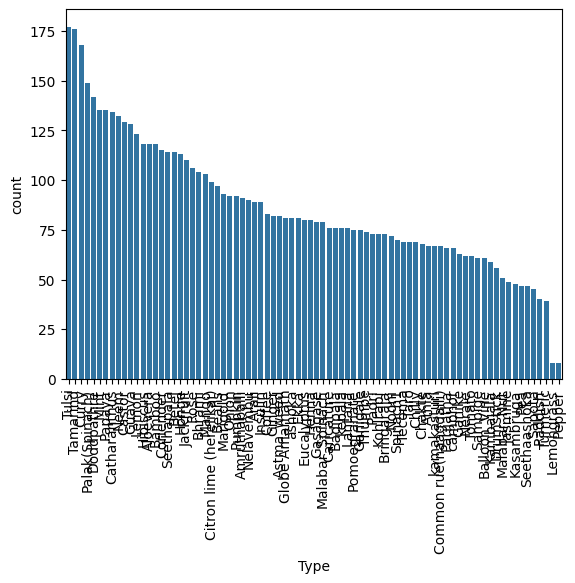

In [35]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [36]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

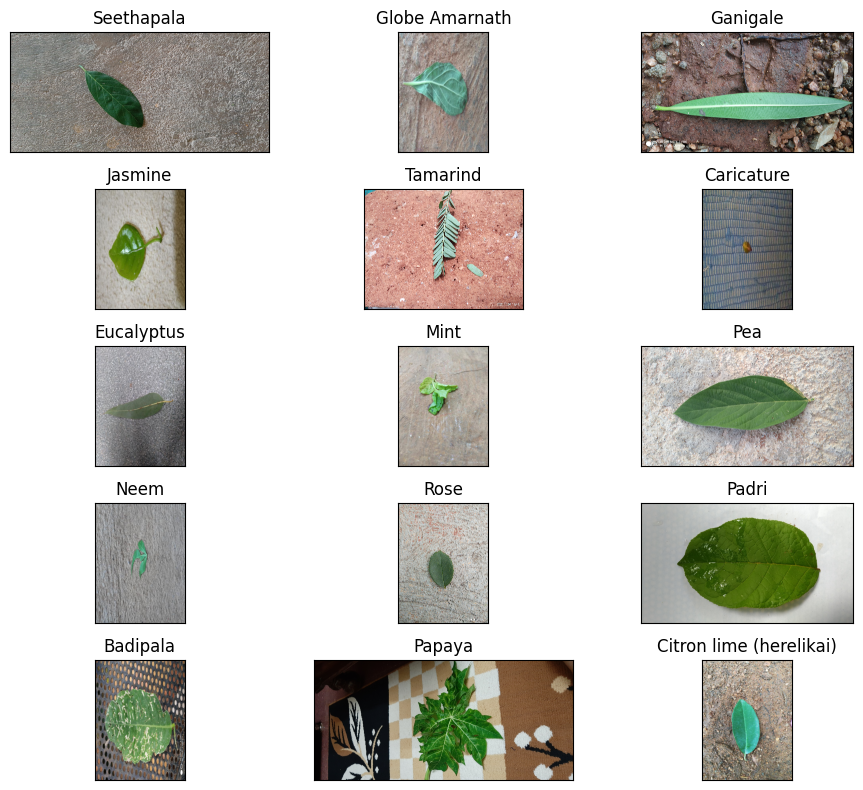

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [38]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [39]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5176 validated image filenames belonging to 80 classes.


C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 5176 validated image filenames belonging to 80 classes.


C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 5176 validated image filenames belonging to 80 classes.


C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [40]:
pretrained_model = ResNet50(
    input_shape=(256,256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [41]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(80, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [42]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [43]:
model.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30
)

Epoch 1/30
162/162 [==============================] - 1519s 9s/step - loss: 2.9569 - accuracy: 0.3039 - val_loss: 1.3681 - val_accuracy: 0.6546
Epoch 2/30
162/162 [==============================] - 1184s 7s/step - loss: 1.0521 - accuracy: 0.7135 - val_loss: 0.6089 - val_accuracy: 0.8439
Epoch 3/30
162/162 [==============================] - 1148s 7s/step - loss: 0.5191 - accuracy: 0.8607 - val_loss: 0.3286 - val_accuracy: 0.9156
Epoch 4/30
162/162 [==============================] - 1150s 7s/step - loss: 0.2987 - accuracy: 0.9247 - val_loss: 0.2466 - val_accuracy: 0.9345
Epoch 5/30
162/162 [==============================] - 1139s 7s/step - loss: 0.1747 - accuracy: 0.9575 - val_loss: 0.1145 - val_accuracy: 0.9784
Epoch 6/30
162/162 [==============================] - 1135s 7s/step - loss: 0.1057 - accuracy: 0.9782 - val_loss: 0.0803 - val_accuracy: 0.9828
Epoch 7/30
162/162 [==============================] - 1448s 9s/step - loss: 0.0720 - accuracy: 0.9861 - val_loss: 0.0433 - val_accuracy:

In [45]:
model.save("model_resnet50.h5")  

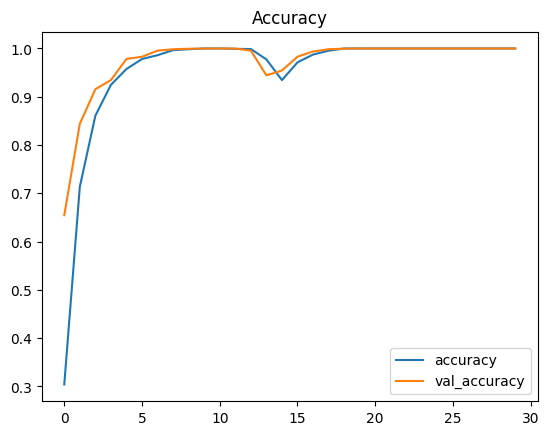

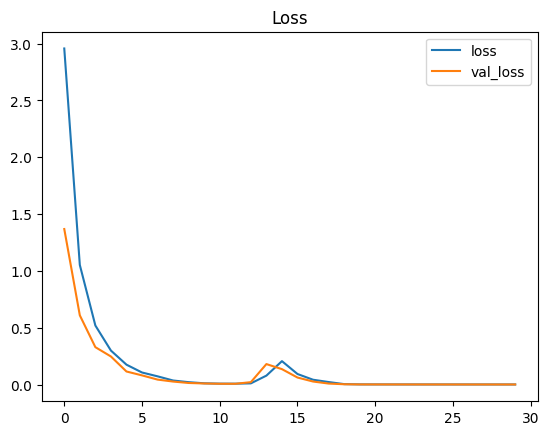

In [46]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [47]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00027
Test Accuracy: 100.00%


In [48]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

162/162 [==============================] - 566s 3s/step


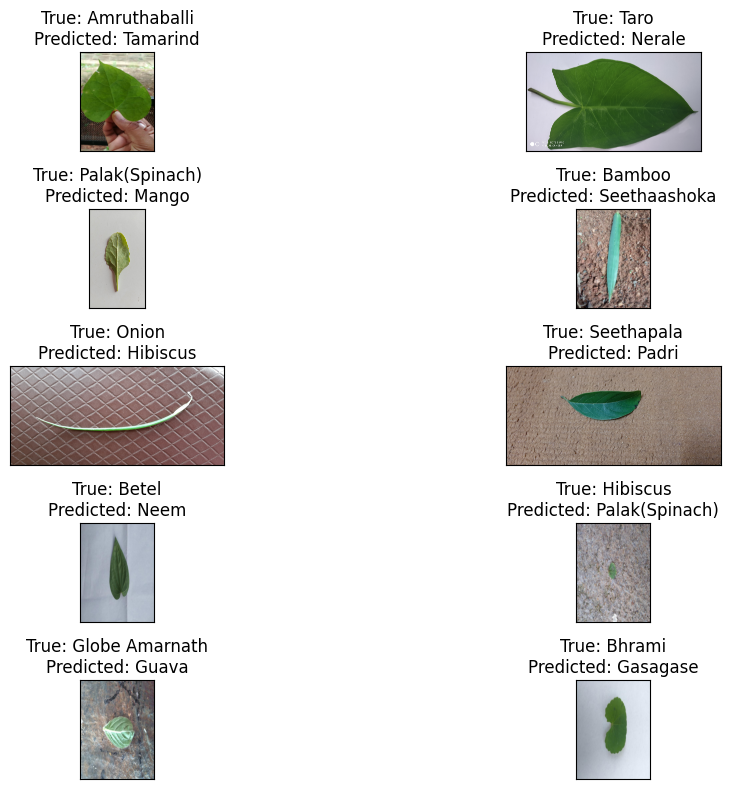

In [50]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [2]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model("model_resnet50.h5")
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
import random

# Load the pre-trained ResNet50 model
loaded_model_imageNet = load_model("model_resnet50.h5")

# Path to your dataset folder
dataset_path = "Medicinal Leaf dataset"

# List of class names (assuming your folder names correspond to class names)
class_names = sorted(os.listdir(dataset_path))

# Number of images to take from each class
num_images_per_class = 10

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the images in the dataset folder
for class_name in tqdm(class_names, desc="Processing images"):
    class_path = os.path.join(dataset_path, class_name)
    # Shuffle the list of image names in each class
    image_names = os.listdir(class_path)
    random.shuffle(image_names)
    # Take the first num_images_per_class images from the shuffled list
    for image_name in tqdm(image_names[:num_images_per_class], desc=class_name, leave=False):
        image_path = os.path.join(class_path, image_name)
        
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (256, 256))
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x)
        
        # Predict using the loaded model
        predictions = loaded_model_imageNet.predict(x)
        predicted_class_index = np.argmax(predictions)
        
        # Append true label and predicted label
        true_labels.append(class_names.index(class_name))
        predicted_labels.append(predicted_class_index)

# Convert true and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Aloevera:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step



Aloevera:  10%|██████████▉                                                                                                  | 1/10 [00:03<00:35,  3.92s/it]

1/1 [==============================] - 2s 2s/step



Aloevera:  20%|█████████████████████▊                                                                                       | 2/10 [00:06<00:25,  3.14s/it]

1/1 [==============================] - 2s 2s/step



Aloevera:  30%|████████████████████████████████▋                                                                            | 3/10 [00:08<00:19,  2.82s/it]

1/1 [==============================] - 3s 3s/step



Aloevera:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:11<00:16,  2.82s/it]

1/1 [==============================] - 3s 3s/step



Aloevera:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:14<00:14,  2.83s/it]

1/1 [==============================] - 3s 3s/step



Aloevera:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:17<00:11,  2.83s/it]

1/1 [==============================] - 2s 2s/step



Aloevera:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:20<00:08,  2.74s/it]

1/1 [==============================] - 2s 2s/step



Aloevera:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:22<00:05,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Aloevera:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:24<00:02,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Amla:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Amla:  10%|███████████▎                                                                                                     | 1/10 [00:01<00:16,  1.87s/it]

1/1 [==============================] - 2s 2s/step



Amla:  20%|██████████████████████▌                                                                                          | 2/10 [00:04<00:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Amla:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:06<00:14,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Amla:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:08<00:11,  1.98s/it]

1/1 [==============================] - 2s 2s/step



Amla:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:09<00:09,  1.89s/it]

1/1 [==============================] - 2s 2s/step



Amla:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:12<00:08,  2.02s/it]

1/1 [==============================] - 2s 2s/step



Amla:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:14<00:06,  2.04s/it]

1/1 [==============================] - 2s 2s/step



Amla:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:16<00:04,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Amla:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:18<00:02,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:   0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  10%|██████████▌                                                                                              | 1/10 [00:02<00:18,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  20%|█████████████████████                                                                                    | 2/10 [00:04<00:16,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  30%|███████████████████████████████▌                                                                         | 3/10 [00:06<00:14,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  40%|██████████████████████████████████████████                                                               | 4/10 [00:08<00:12,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  50%|████████████████████████████████████████████████████▌                                                    | 5/10 [00:10<00:10,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  60%|███████████████████████████████████████████████████████████████                                          | 6/10 [00:12<00:08,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [00:14<00:06,  2.09s/it]

1/1 [==============================] - 1s 955ms/step



Amruthaballi:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [00:15<00:03,  1.77s/it]

1/1 [==============================] - 2s 2s/step



Amruthaballi:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [00:17<00:01,  1.82s/it]

1/1 [==============================] - 2s 2s/step



Arali:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Arali:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:18,  2.01s/it]

1/1 [==============================] - 2s 2s/step



Arali:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:16,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Arali:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:14,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Arali:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:12,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Arali:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:10<00:10,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Arali:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:12<00:08,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Arali:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:14<00:06,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Arali:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:16<00:04,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Arali:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:18<00:02,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Astma_weed:  10%|██████████▋                                                                                                | 1/10 [00:02<00:18,  2.02s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:17,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  30%|████████████████████████████████                                                                           | 3/10 [00:07<00:17,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:09<00:14,  2.36s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:11<00:11,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:13<00:08,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:15<00:06,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:17<00:04,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Astma_weed:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:19<00:02,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Badipala:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Badipala:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:20,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  20%|█████████████████████▊                                                                                       | 2/10 [00:04<00:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  30%|████████████████████████████████▋                                                                            | 3/10 [00:06<00:14,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:08<00:12,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:10<00:10,  2.04s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:12<00:08,  2.03s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:14<00:06,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:16<00:04,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Badipala:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:19<00:02,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:   0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  10%|██████████▌                                                                                              | 1/10 [00:02<00:18,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  20%|█████████████████████                                                                                    | 2/10 [00:04<00:16,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  30%|███████████████████████████████▌                                                                         | 3/10 [00:06<00:14,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  40%|██████████████████████████████████████████                                                               | 4/10 [00:08<00:12,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  50%|████████████████████████████████████████████████████▌                                                    | 5/10 [00:10<00:10,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  60%|███████████████████████████████████████████████████████████████                                          | 6/10 [00:12<00:08,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [00:14<00:06,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [00:16<00:04,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Balloon_Vine:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [00:18<00:02,  2.06s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Bamboo:  10%|███████████                                                                                                    | 1/10 [00:02<00:18,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:16,  2.10s/it]

1/1 [==============================] - 1s 1s/step



Bamboo:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:05<00:13,  1.87s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:07<00:11,  1.97s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:09<00:09,  1.98s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:12<00:08,  2.02s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:14<00:06,  2.05s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:16<00:04,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Bamboo:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:18<00:02,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Beans:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Beans:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:18,  2.06s/it]

1/1 [==============================] - 2s 2s/step



Beans:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:16,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Beans:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:14,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Beans:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:12,  2.06s/it]

1/1 [==============================] - 2s 2s/step



Beans:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:10<00:10,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Beans:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:12<00:08,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Beans:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:14<00:06,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Beans:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:16<00:04,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Beans:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:18<00:02,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Betel:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Betel:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:18,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Betel:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:16,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Betel:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:14,  2.00s/it]

1/1 [==============================] - 2s 2s/step



Betel:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:12,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Betel:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:10<00:10,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Betel:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:12<00:08,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Betel:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:14<00:06,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Betel:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:16<00:04,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Betel:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:18<00:02,  2.09s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Bhrami:  10%|███████████                                                                                                    | 1/10 [00:02<00:20,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:17,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:15,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:10<00:10,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:15<00:06,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:17<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Bhrami:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:19<00:02,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Bringaraja:  10%|██████████▋                                                                                                | 1/10 [00:02<00:25,  2.84s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  20%|█████████████████████▍                                                                                     | 2/10 [00:05<00:21,  2.70s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  30%|████████████████████████████████                                                                           | 3/10 [00:08<00:18,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:10<00:15,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:12<00:12,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:15<00:09,  2.39s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:17<00:07,  2.35s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:19<00:04,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Bringaraja:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:21<00:02,  2.35s/it]

1/1 [==============================] - 2s 2s/step



Caricature:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Caricature:  10%|██████████▋                                                                                                | 1/10 [00:02<00:19,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:16,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  30%|████████████████████████████████                                                                           | 3/10 [00:06<00:14,  2.05s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:08<00:12,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:10<00:10,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:14<00:06,  2.19s/it]

1/1 [==============================] - 3s 3s/step



Caricature:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:17<00:04,  2.37s/it]

1/1 [==============================] - 2s 2s/step



Caricature:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:20<00:02,  2.41s/it]

1/1 [==============================] - 3s 3s/step



Castor:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Castor:  10%|███████████                                                                                                    | 1/10 [00:02<00:20,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Castor:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:18,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Castor:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:15,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Castor:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:08<00:13,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Castor:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:11<00:10,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Castor:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:13<00:08,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Castor:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:15<00:06,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Castor:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:17<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Castor:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:19<00:02,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:   0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Catharanthus:  10%|██████████▌                                                                                              | 1/10 [00:02<00:18,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  20%|█████████████████████                                                                                    | 2/10 [00:04<00:17,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  30%|███████████████████████████████▌                                                                         | 3/10 [00:06<00:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  40%|██████████████████████████████████████████                                                               | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  50%|████████████████████████████████████████████████████▌                                                    | 5/10 [00:10<00:10,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  60%|███████████████████████████████████████████████████████████████                                          | 6/10 [00:12<00:08,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [00:15<00:06,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [00:17<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Catharanthus:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [00:19<00:02,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Chakte:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Chakte:  10%|███████████                                                                                                    | 1/10 [00:02<00:18,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:16,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:08<00:12,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:10<00:10,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:14<00:06,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:17<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chakte:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:19<00:02,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Chilly:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Chilly:  10%|███████████                                                                                                    | 1/10 [00:02<00:18,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:17,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:08<00:12,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:10<00:10,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:12<00:08,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:14<00:06,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:17<00:04,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Chilly:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:19<00:02,  2.34s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):   0%|                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  10%|█████████▍                                                                                    | 1/10 [00:02<00:20,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  20%|██████████████████▊                                                                           | 2/10 [00:04<00:18,  2.32s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  30%|████████████████████████████▏                                                                 | 3/10 [00:06<00:15,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  40%|█████████████████████████████████████▌                                                        | 4/10 [00:09<00:13,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  50%|███████████████████████████████████████████████                                               | 5/10 [00:11<00:11,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  60%|████████████████████████████████████████████████████████▍                                     | 6/10 [00:13<00:08,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  70%|█████████████████████████████████████████████████████████████████▊                            | 7/10 [00:15<00:06,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  80%|███████████████████████████████████████████████████████████████████████████▏                  | 8/10 [00:17<00:04,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Citron lime (herelikai):  90%|████████████████████████████████████████████████████████████████████████████████████▌         | 9/10 [00:20<00:02,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Coffee:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Coffee:  10%|███████████                                                                                                    | 1/10 [00:02<00:20,  2.30s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:20,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:17,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:09<00:14,  2.40s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:11<00:11,  2.37s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:14<00:09,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:17<00:07,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:19<00:04,  2.42s/it]

1/1 [==============================] - 2s 2s/step



Coffee:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:21<00:02,  2.37s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):   0%|                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  10%|█████████▌                                                                                      | 1/10 [00:02<00:19,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  20%|███████████████████▏                                                                            | 2/10 [00:04<00:16,  2.10s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  30%|████████████████████████████▊                                                                   | 3/10 [00:06<00:14,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  40%|██████████████████████████████████████▍                                                         | 4/10 [00:08<00:12,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  50%|████████████████████████████████████████████████                                                | 5/10 [00:10<00:10,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  60%|█████████████████████████████████████████████████████████▌                                      | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  70%|███████████████████████████████████████████████████████████████████▏                            | 7/10 [00:14<00:06,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  80%|████████████████████████████████████████████████████████████████████████████▊                   | 8/10 [00:16<00:04,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Common rue(naagdalli):  90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 9/10 [00:19<00:02,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Coriender:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Coriender:  10%|██████████▊                                                                                                 | 1/10 [00:02<00:18,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  20%|█████████████████████▌                                                                                      | 2/10 [00:04<00:16,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  30%|████████████████████████████████▍                                                                           | 3/10 [00:06<00:14,  2.08s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:08<00:12,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:10<00:10,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:14<00:06,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:16<00:04,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Coriender:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:19<00:02,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Curry:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Curry:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Curry:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Curry:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:14,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Curry:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Curry:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:10<00:10,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Curry:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:12<00:08,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Curry:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Curry:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:17<00:04,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Curry:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:19<00:02,  2.30s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Doddpathre:  10%|██████████▋                                                                                                | 1/10 [00:02<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:19,  2.39s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  30%|████████████████████████████████                                                                           | 3/10 [00:06<00:16,  2.30s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:09<00:13,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:11<00:11,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:13<00:08,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:15<00:06,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:17<00:04,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Doddpathre:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:19<00:02,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Drumstick:  10%|██████████▊                                                                                                 | 1/10 [00:01<00:16,  1.87s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  20%|█████████████████████▌                                                                                      | 2/10 [00:04<00:16,  2.07s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  30%|████████████████████████████████▍                                                                           | 3/10 [00:06<00:14,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:10<00:10,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:12<00:08,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:15<00:06,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:17<00:04,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Drumstick:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:19<00:02,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Ekka:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Ekka:  10%|███████████▎                                                                                                     | 1/10 [00:02<00:19,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  20%|██████████████████████▌                                                                                          | 2/10 [00:04<00:16,  2.12s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:06<00:14,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:10<00:10,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:12<00:08,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:15<00:06,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:17<00:04,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Ekka:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:19<00:02,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  10%|██████████▋                                                                                                | 1/10 [00:02<00:19,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:17,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  30%|████████████████████████████████                                                                           | 3/10 [00:06<00:15,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:08<00:12,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:10<00:10,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:12<00:08,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:15<00:06,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:17<00:04,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Eucalyptus:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:19<00:02,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Ganigale:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:22,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  20%|█████████████████████▊                                                                                       | 2/10 [00:05<00:20,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  30%|████████████████████████████████▋                                                                            | 3/10 [00:07<00:17,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:09<00:14,  2.43s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:12<00:12,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:14<00:09,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:17<00:07,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:19<00:05,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Ganigale:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:22<00:02,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Ganike:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Ganike:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:17,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:12<00:12,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:17<00:07,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:04,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Ganike:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:22<00:02,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Gasagase:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:19,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  20%|█████████████████████▊                                                                                       | 2/10 [00:04<00:17,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  30%|████████████████████████████████▋                                                                            | 3/10 [00:06<00:14,  2.05s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:08<00:12,  2.13s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:10<00:10,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:12<00:08,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:15<00:06,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:17<00:04,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Gasagase:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:19<00:02,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Ginger:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Ginger:  10%|███████████                                                                                                    | 1/10 [00:02<00:19,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:17,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:15,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:08<00:13,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:10<00:10,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:13<00:08,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:15<00:06,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:17<00:04,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Ginger:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:19<00:02,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  10%|██████████▎                                                                                            | 1/10 [00:02<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  20%|████████████████████▌                                                                                  | 2/10 [00:04<00:17,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  30%|██████████████████████████████▉                                                                        | 3/10 [00:06<00:15,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  40%|█████████████████████████████████████████▏                                                             | 4/10 [00:08<00:13,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  50%|███████████████████████████████████████████████████▌                                                   | 5/10 [00:10<00:10,  2.11s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  60%|█████████████████████████████████████████████████████████████▊                                         | 6/10 [00:12<00:08,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  70%|████████████████████████████████████████████████████████████████████████                               | 7/10 [00:15<00:06,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 8/10 [00:17<00:04,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Globe Amarnath:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 9/10 [00:19<00:02,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Guava:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Guava:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Guava:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Guava:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Guava:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:13,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Guava:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:10<00:10,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Guava:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:08,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Guava:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Guava:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:17<00:04,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Guava:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:20<00:02,  2.30s/it]

1/1 [==============================] - 2s 2s/step



Henna:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Henna:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Henna:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Henna:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Henna:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:13,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Henna:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:11<00:11,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Henna:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:08,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Henna:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Henna:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:17<00:04,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Henna:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:19<00:02,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Hibiscus:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  20%|█████████████████████▊                                                                                       | 2/10 [00:04<00:17,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  30%|████████████████████████████████▋                                                                            | 3/10 [00:06<00:15,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:08<00:13,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:11<00:11,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:13<00:08,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:15<00:06,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:17<00:04,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Hibiscus:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:19<00:02,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Honge:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Honge:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Honge:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Honge:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Honge:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:13,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Honge:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:11<00:11,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Honge:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:08,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Honge:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Honge:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:17<00:04,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Honge:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:20<00:02,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Insulin:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step



Insulin:  10%|███████████                                                                                                   | 1/10 [00:02<00:26,  2.90s/it]

1/1 [==============================] - 2s 2s/step



Insulin:  20%|██████████████████████                                                                                        | 2/10 [00:05<00:19,  2.44s/it]

1/1 [==============================] - 2s 2s/step



Insulin:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:17,  2.48s/it]

1/1 [==============================] - 3s 3s/step



Insulin:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:10<00:15,  2.63s/it]

1/1 [==============================] - 3s 3s/step



Insulin:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:13<00:13,  2.75s/it]

1/1 [==============================] - 2s 2s/step



Insulin:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:15<00:10,  2.64s/it]

1/1 [==============================] - 2s 2s/step



Insulin:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:18<00:07,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Insulin:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:20<00:05,  2.61s/it]

1/1 [==============================] - 3s 3s/step



Insulin:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Jackfruit:  10%|██████████▊                                                                                                 | 1/10 [00:02<00:20,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  20%|█████████████████████▌                                                                                      | 2/10 [00:04<00:18,  2.28s/it]

1/1 [==============================] - 3s 3s/step



Jackfruit:  30%|████████████████████████████████▍                                                                           | 3/10 [00:07<00:17,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:09<00:14,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:12<00:12,  2.41s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:14<00:09,  2.35s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:16<00:06,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:18<00:04,  2.28s/it]

1/1 [==============================] - 2s 2s/step



Jackfruit:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:20<00:02,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Jasmine:  10%|███████████                                                                                                   | 1/10 [00:02<00:19,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  20%|██████████████████████                                                                                        | 2/10 [00:04<00:17,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  30%|█████████████████████████████████                                                                             | 3/10 [00:06<00:15,  2.14s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:08<00:12,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:10<00:10,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:13<00:09,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:15<00:06,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:17<00:04,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Jasmine:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:20<00:02,  2.28s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Kambajala:  10%|██████████▊                                                                                                 | 1/10 [00:02<00:19,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  20%|█████████████████████▌                                                                                      | 2/10 [00:04<00:17,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  30%|████████████████████████████████▍                                                                           | 3/10 [00:06<00:15,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:08<00:13,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:11<00:11,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:13<00:08,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:15<00:06,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:17<00:04,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Kambajala:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:19<00:02,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Kasambruga:  10%|██████████▋                                                                                                | 1/10 [00:02<00:19,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:17,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  30%|████████████████████████████████                                                                           | 3/10 [00:06<00:15,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:08<00:13,  2.19s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:11<00:11,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:13<00:08,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:15<00:06,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:17<00:04,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kasambruga:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:19<00:02,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:22,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  20%|█████████████████████▊                                                                                       | 2/10 [00:05<00:20,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  30%|████████████████████████████████▋                                                                            | 3/10 [00:07<00:18,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:10<00:15,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:12<00:12,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:15<00:10,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:18<00:07,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:20<00:05,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Kohlrabi:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Lantana:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Lantana:  10%|███████████                                                                                                   | 1/10 [00:02<00:21,  2.35s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  20%|██████████████████████                                                                                        | 2/10 [00:04<00:18,  2.28s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:17,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:09<00:15,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:12<00:13,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:15<00:10,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:18<00:08,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:20<00:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Lantana:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Lemon:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Lemon:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:13,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:11<00:11,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:08,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:17<00:04,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Lemon:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:20<00:02,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:   0%|                                                                                                                    | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Lemongrass:  12%|█████████████▌                                                                                              | 1/8 [00:02<00:15,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  25%|███████████████████████████                                                                                 | 2/8 [00:04<00:13,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  38%|████████████████████████████████████████▌                                                                   | 3/8 [00:06<00:11,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  50%|██████████████████████████████████████████████████████                                                      | 4/8 [00:08<00:08,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  62%|███████████████████████████████████████████████████████████████████▌                                        | 5/8 [00:11<00:06,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  75%|█████████████████████████████████████████████████████████████████████████████████                           | 6/8 [00:13<00:04,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Lemongrass:  88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 7/8 [00:15<00:02,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:   0%|                                                                                                                  | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  10%|██████████▌                                                                                               | 1/10 [00:02<00:22,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  20%|█████████████████████▏                                                                                    | 2/10 [00:04<00:17,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  30%|███████████████████████████████▊                                                                          | 3/10 [00:07<00:16,  2.37s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  40%|██████████████████████████████████████████▍                                                               | 4/10 [00:09<00:15,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  50%|█████████████████████████████████████████████████████                                                     | 5/10 [00:12<00:12,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  60%|███████████████████████████████████████████████████████████████▌                                          | 6/10 [00:14<00:09,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 7/10 [00:17<00:07,  2.43s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 8/10 [00:19<00:04,  2.40s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Nut:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 9/10 [00:21<00:02,  2.44s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:   0%|                                                                                                              | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  10%|██████████▏                                                                                           | 1/10 [00:02<00:19,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  20%|████████████████████▍                                                                                 | 2/10 [00:04<00:17,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  30%|██████████████████████████████▌                                                                       | 3/10 [00:06<00:15,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  40%|████████████████████████████████████████▊                                                             | 4/10 [00:08<00:13,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  50%|███████████████████████████████████████████████████                                                   | 5/10 [00:11<00:11,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  60%|█████████████████████████████████████████████████████████████▏                                        | 6/10 [00:13<00:08,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  70%|███████████████████████████████████████████████████████████████████████▍                              | 7/10 [00:15<00:06,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 8/10 [00:17<00:04,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Malabar_Spinach:  90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 9/10 [00:20<00:02,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Mango:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Mango:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:19,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Mango:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Mango:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Mango:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:08<00:13,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Mango:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:11<00:11,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Mango:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:09,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Mango:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:15<00:06,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Mango:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:18<00:04,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Mango:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:20<00:02,  2.26s/it]

1/1 [==============================] - 2s 2s/step



Marigold:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Marigold:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:21,  2.41s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  20%|█████████████████████▊                                                                                       | 2/10 [00:04<00:18,  2.37s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  30%|████████████████████████████████▋                                                                            | 3/10 [00:06<00:16,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:09<00:13,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:11<00:11,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:13<00:09,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:15<00:06,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:18<00:04,  2.25s/it]

1/1 [==============================] - 2s 2s/step



Marigold:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:20<00:02,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Mint:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Mint:  10%|███████████▎                                                                                                     | 1/10 [00:02<00:19,  2.21s/it]

1/1 [==============================] - 2s 2s/step



Mint:  20%|██████████████████████▌                                                                                          | 2/10 [00:04<00:17,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Mint:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:06<00:15,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Mint:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:08<00:13,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Mint:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:11<00:11,  2.26s/it]

1/1 [==============================] - 3s 3s/step



Mint:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:13<00:09,  2.41s/it]

1/1 [==============================] - 2s 2s/step



Mint:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:16<00:07,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Mint:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:18<00:04,  2.41s/it]

1/1 [==============================] - 2s 2s/step



Mint:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:20<00:02,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Neem:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Neem:  10%|███████████▎                                                                                                     | 1/10 [00:02<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step



Neem:  20%|██████████████████████▌                                                                                          | 2/10 [00:04<00:19,  2.47s/it]

1/1 [==============================] - 3s 3s/step



Neem:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:07<00:18,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Neem:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:09<00:14,  2.49s/it]

1/1 [==============================] - 3s 3s/step



Neem:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:12<00:13,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Neem:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:14<00:09,  2.36s/it]

1/1 [==============================] - 2s 2s/step



Neem:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:17<00:07,  2.39s/it]

1/1 [==============================] - 2s 2s/step



Neem:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:19<00:04,  2.37s/it]

1/1 [==============================] - 3s 3s/step



Neem:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:22<00:02,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Nelavembu:  10%|██████████▊                                                                                                 | 1/10 [00:02<00:20,  2.22s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  20%|█████████████████████▌                                                                                      | 2/10 [00:04<00:17,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  30%|████████████████████████████████▍                                                                           | 3/10 [00:06<00:15,  2.24s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:08<00:13,  2.20s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:11<00:11,  2.23s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:13<00:08,  2.15s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:15<00:06,  2.30s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:18<00:04,  2.31s/it]

1/1 [==============================] - 2s 2s/step



Nelavembu:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:20<00:02,  2.29s/it]

1/1 [==============================] - 2s 2s/step



Nerale:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Nerale:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:17,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:12<00:12,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:09,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:17<00:07,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Nerale:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Nooni:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Nooni:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:22,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  20%|██████████████████████▍                                                                                         | 2/10 [00:05<00:20,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:07<00:17,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:10<00:15,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:12<00:12,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:15<00:10,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:18<00:08,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:20<00:05,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Nooni:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:23<00:02,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Onion:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Onion:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:22,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Onion:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:19,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Onion:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:07<00:17,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Onion:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:09<00:14,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Onion:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:12<00:12,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Onion:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:14<00:09,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Onion:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:17<00:07,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Onion:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:19<00:05,  2.50s/it]

1/1 [==============================] - 2s 2s/step



Onion:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:22<00:02,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Padri:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Padri:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:21,  2.35s/it]

1/1 [==============================] - 2s 2s/step



Padri:  20%|██████████████████████▍                                                                                         | 2/10 [00:04<00:17,  2.18s/it]

1/1 [==============================] - 2s 2s/step



Padri:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:06<00:15,  2.27s/it]

1/1 [==============================] - 2s 2s/step



Padri:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:09<00:13,  2.28s/it]

1/1 [==============================] - 2s 2s/step



Padri:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:11<00:11,  2.32s/it]

1/1 [==============================] - 2s 2s/step



Padri:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:13<00:09,  2.34s/it]

1/1 [==============================] - 2s 2s/step



Padri:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:16<00:07,  2.36s/it]

1/1 [==============================] - 2s 2s/step



Padri:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:18<00:04,  2.38s/it]

1/1 [==============================] - 2s 2s/step



Padri:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:21<00:02,  2.39s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  10%|██████████▎                                                                                            | 1/10 [00:02<00:22,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  20%|████████████████████▌                                                                                  | 2/10 [00:05<00:20,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  30%|██████████████████████████████▉                                                                        | 3/10 [00:07<00:17,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  40%|█████████████████████████████████████████▏                                                             | 4/10 [00:10<00:15,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  50%|███████████████████████████████████████████████████▌                                                   | 5/10 [00:12<00:12,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  60%|█████████████████████████████████████████████████████████████▊                                         | 6/10 [00:15<00:10,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  70%|████████████████████████████████████████████████████████████████████████                               | 7/10 [00:17<00:07,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 8/10 [00:20<00:05,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Palak(Spinach):  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 9/10 [00:22<00:02,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Papaya:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Papaya:  10%|███████████                                                                                                    | 1/10 [00:02<00:22,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:17,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:12<00:12,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:17<00:07,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:05,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Papaya:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:   0%|                                                                                                                    | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Parijatha:  10%|██████████▊                                                                                                 | 1/10 [00:02<00:22,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  20%|█████████████████████▌                                                                                      | 2/10 [00:05<00:20,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  30%|████████████████████████████████▍                                                                           | 3/10 [00:07<00:17,  2.51s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  40%|███████████████████████████████████████████▏                                                                | 4/10 [00:10<00:15,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  50%|██████████████████████████████████████████████████████                                                      | 5/10 [00:12<00:12,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  60%|████████████████████████████████████████████████████████████████▊                                           | 6/10 [00:15<00:10,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  70%|███████████████████████████████████████████████████████████████████████████▌                                | 7/10 [00:17<00:07,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 8/10 [00:20<00:05,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Parijatha:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9/10 [00:22<00:02,  2.52s/it]

1/1 [==============================] - 2s 2s/step



Pea:   0%|                                                                                                                          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Pea:  10%|███████████▍                                                                                                      | 1/10 [00:02<00:22,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Pea:  20%|██████████████████████▊                                                                                           | 2/10 [00:05<00:20,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Pea:  30%|██████████████████████████████████▏                                                                               | 3/10 [00:07<00:18,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Pea:  40%|█████████████████████████████████████████████▌                                                                    | 4/10 [00:10<00:15,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pea:  50%|█████████████████████████████████████████████████████████                                                         | 5/10 [00:13<00:13,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Pea:  60%|████████████████████████████████████████████████████████████████████▍                                             | 6/10 [00:15<00:10,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Pea:  70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 7/10 [00:18<00:07,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Pea:  80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 8/10 [00:20<00:05,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Pea:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9/10 [00:23<00:02,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Pepper:   0%|                                                                                                                        | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Pepper:  12%|██████████████                                                                                                  | 1/8 [00:02<00:19,  2.84s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  25%|████████████████████████████                                                                                    | 2/8 [00:05<00:16,  2.82s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  38%|██████████████████████████████████████████                                                                      | 3/8 [00:08<00:13,  2.77s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  50%|████████████████████████████████████████████████████████                                                        | 4/8 [00:11<00:11,  2.75s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  62%|██████████████████████████████████████████████████████████████████████                                          | 5/8 [00:13<00:08,  2.74s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  75%|████████████████████████████████████████████████████████████████████████████████████                            | 6/8 [00:16<00:05,  2.73s/it]

1/1 [==============================] - 2s 2s/step



Pepper:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 7/8 [00:19<00:02,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:   0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  10%|██████████▌                                                                                              | 1/10 [00:02<00:23,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  20%|█████████████████████                                                                                    | 2/10 [00:05<00:20,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  30%|███████████████████████████████▌                                                                         | 3/10 [00:07<00:18,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  40%|██████████████████████████████████████████                                                               | 4/10 [00:10<00:15,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  50%|████████████████████████████████████████████████████▌                                                    | 5/10 [00:13<00:13,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  60%|███████████████████████████████████████████████████████████████                                          | 6/10 [00:15<00:10,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [00:18<00:07,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [00:20<00:05,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Pomoegranate:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [00:23<00:02,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Pumpkin:  10%|███████████                                                                                                   | 1/10 [00:02<00:20,  2.33s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  20%|██████████████████████                                                                                        | 2/10 [00:04<00:19,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:19,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:10<00:15,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:13<00:13,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:15<00:10,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:18<00:07,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:20<00:05,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Pumpkin:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Raddish:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Raddish:  10%|███████████                                                                                                   | 1/10 [00:02<00:22,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  20%|██████████████████████                                                                                        | 2/10 [00:05<00:21,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:18,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:10<00:16,  2.69s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:13<00:13,  2.68s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:15<00:10,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:18<00:08,  2.68s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:21<00:05,  2.68s/it]

1/1 [==============================] - 2s 2s/step



Raddish:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:24<00:02,  2.70s/it]

1/1 [==============================] - 2s 2s/step



Rose:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Rose:  10%|███████████▎                                                                                                     | 1/10 [00:02<00:24,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Rose:  20%|██████████████████████▌                                                                                          | 2/10 [00:05<00:22,  2.76s/it]

1/1 [==============================] - 2s 2s/step



Rose:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:08<00:19,  2.76s/it]

1/1 [==============================] - 2s 2s/step



Rose:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:10<00:16,  2.74s/it]

1/1 [==============================] - 2s 2s/step



Rose:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:13<00:13,  2.76s/it]

1/1 [==============================] - 2s 2s/step



Rose:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:16<00:10,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Rose:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:19<00:08,  2.77s/it]

1/1 [==============================] - 2s 2s/step



Rose:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:22<00:05,  2.75s/it]

1/1 [==============================] - 2s 2s/step



Rose:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:24<00:02,  2.75s/it]

1/1 [==============================] - 2s 2s/step



Sampige:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Sampige:  10%|███████████                                                                                                   | 1/10 [00:02<00:22,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  20%|██████████████████████                                                                                        | 2/10 [00:05<00:20,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:17,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:10<00:15,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:12<00:12,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:15<00:10,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:18<00:07,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Sampige:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:20<00:05,  2.64s/it]

1/1 [==============================] - 3s 3s/step



Sampige:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.82s/it]

1/1 [==============================] - 2s 2s/step



Sapota:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Sapota:  10%|███████████                                                                                                    | 1/10 [00:02<00:24,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:18,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:12<00:12,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:18<00:07,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:05,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Sapota:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:   0%|                                                                                                                 | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  10%|██████████▌                                                                                              | 1/10 [00:02<00:22,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  20%|█████████████████████                                                                                    | 2/10 [00:04<00:19,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  30%|███████████████████████████████▌                                                                         | 3/10 [00:07<00:17,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  40%|██████████████████████████████████████████                                                               | 4/10 [00:09<00:14,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  50%|████████████████████████████████████████████████████▌                                                    | 5/10 [00:12<00:12,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  60%|███████████████████████████████████████████████████████████████                                          | 6/10 [00:14<00:09,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  70%|█████████████████████████████████████████████████████████████████████████▌                               | 7/10 [00:17<00:07,  2.47s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 8/10 [00:19<00:04,  2.48s/it]

1/1 [==============================] - 2s 2s/step



Seethaashoka:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 9/10 [00:22<00:02,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:   0%|                                                                                                                   | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Seethapala:  10%|██████████▋                                                                                                | 1/10 [00:02<00:22,  2.48s/it]

1/1 [==============================] - 1s 1s/step



Seethapala:  20%|█████████████████████▍                                                                                     | 2/10 [00:04<00:17,  2.16s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  30%|████████████████████████████████                                                                           | 3/10 [00:06<00:16,  2.32s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  40%|██████████████████████████████████████████▊                                                                | 4/10 [00:09<00:14,  2.42s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:12<00:12,  2.45s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:14<00:09,  2.49s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:17<00:07,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:19<00:05,  2.55s/it]

1/1 [==============================] - 2s 2s/step



Seethapala:  90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:22<00:02,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Spinach1:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:22,  2.46s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  20%|█████████████████████▊                                                                                       | 2/10 [00:05<00:20,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  30%|████████████████████████████████▋                                                                            | 3/10 [00:07<00:16,  2.40s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:10<00:15,  2.53s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:12<00:12,  2.56s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:15<00:10,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:17<00:07,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:20<00:05,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Spinach1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Tamarind:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:24,  2.71s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  20%|█████████████████████▊                                                                                       | 2/10 [00:05<00:22,  2.80s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  30%|████████████████████████████████▋                                                                            | 3/10 [00:08<00:19,  2.77s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:10<00:16,  2.74s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:14<00:14,  2.85s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:16<00:11,  2.80s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:19<00:08,  2.79s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:22<00:05,  2.77s/it]

1/1 [==============================] - 2s 2s/step



Tamarind:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:24<00:02,  2.74s/it]

1/1 [==============================] - 2s 2s/step



Taro:   0%|                                                                                                                         | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Taro:  10%|███████████▎                                                                                                     | 1/10 [00:02<00:24,  2.69s/it]

1/1 [==============================] - 2s 2s/step



Taro:  20%|██████████████████████▌                                                                                          | 2/10 [00:05<00:22,  2.79s/it]

1/1 [==============================] - 2s 2s/step



Taro:  30%|█████████████████████████████████▉                                                                               | 3/10 [00:08<00:19,  2.73s/it]

1/1 [==============================] - 2s 2s/step



Taro:  40%|█████████████████████████████████████████████▏                                                                   | 4/10 [00:10<00:15,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Taro:  50%|████████████████████████████████████████████████████████▌                                                        | 5/10 [00:13<00:13,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Taro:  60%|███████████████████████████████████████████████████████████████████▊                                             | 6/10 [00:16<00:10,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Taro:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 7/10 [00:18<00:07,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Taro:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 8/10 [00:21<00:05,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Taro:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9/10 [00:23<00:02,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Tecoma:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.58s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:18,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:13<00:13,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:18<00:07,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:21<00:05,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Tecoma:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Thumbe:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:21,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:18,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:13<00:13,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.68s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:18<00:08,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:20<00:05,  2.54s/it]

1/1 [==============================] - 2s 2s/step



Thumbe:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.57s/it]

1/1 [==============================] - 2s 2s/step



Tomato:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Tomato:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.63s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:20,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:18,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:15,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:13<00:13,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:15<00:10,  2.68s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:18<00:08,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:21<00:05,  2.71s/it]

1/1 [==============================] - 2s 2s/step



Tomato:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:23<00:02,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:   0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Tulsi:  10%|███████████▏                                                                                                    | 1/10 [00:02<00:25,  2.83s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  20%|██████████████████████▍                                                                                         | 2/10 [00:05<00:21,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  30%|█████████████████████████████████▌                                                                              | 3/10 [00:08<00:19,  2.72s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  40%|████████████████████████████████████████████▊                                                                   | 4/10 [00:10<00:15,  2.64s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  50%|████████████████████████████████████████████████████████                                                        | 5/10 [00:13<00:13,  2.66s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  60%|███████████████████████████████████████████████████████████████████▏                                            | 6/10 [00:16<00:10,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:18<00:07,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 8/10 [00:21<00:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Tulsi:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9/10 [00:23<00:02,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:   0%|                                                                                                                     | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Turmeric:  10%|██████████▉                                                                                                  | 1/10 [00:02<00:23,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  20%|█████████████████████▊                                                                                       | 2/10 [00:05<00:20,  2.60s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  30%|████████████████████████████████▋                                                                            | 3/10 [00:07<00:18,  2.61s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  40%|███████████████████████████████████████████▌                                                                 | 4/10 [00:10<00:15,  2.64s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  50%|██████████████████████████████████████████████████████▌                                                      | 5/10 [00:13<00:12,  2.59s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  60%|█████████████████████████████████████████████████████████████████▍                                           | 6/10 [00:15<00:10,  2.65s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  70%|████████████████████████████████████████████████████████████████████████████▎                                | 7/10 [00:18<00:07,  2.64s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8/10 [00:20<00:05,  2.62s/it]

1/1 [==============================] - 2s 2s/step



Turmeric:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:23<00:02,  2.63s/it]

1/1 [==============================] - 2s 2s/step



ashoka:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



ashoka:  10%|███████████                                                                                                    | 1/10 [00:02<00:20,  2.28s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:18,  2.35s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:07<00:17,  2.43s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:09<00:14,  2.40s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:11<00:11,  2.40s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:14<00:09,  2.38s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:16<00:07,  2.39s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:19<00:04,  2.42s/it]

1/1 [==============================] - 2s 2s/step



ashoka:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:21<00:02,  2.44s/it]

1/1 [==============================] - 2s 2s/step



camphor:   0%|                                                                                                                      | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



camphor:  10%|███████████                                                                                                   | 1/10 [00:02<00:21,  2.41s/it]

1/1 [==============================] - 2s 2s/step



camphor:  20%|██████████████████████                                                                                        | 2/10 [00:04<00:20,  2.51s/it]

1/1 [==============================] - 2s 2s/step



camphor:  30%|█████████████████████████████████                                                                             | 3/10 [00:07<00:17,  2.49s/it]

1/1 [==============================] - 2s 2s/step



camphor:  40%|████████████████████████████████████████████                                                                  | 4/10 [00:09<00:14,  2.47s/it]

1/1 [==============================] - 2s 2s/step



camphor:  50%|███████████████████████████████████████████████████████                                                       | 5/10 [00:12<00:11,  2.38s/it]

1/1 [==============================] - 2s 2s/step



camphor:  60%|██████████████████████████████████████████████████████████████████                                            | 6/10 [00:14<00:09,  2.41s/it]

1/1 [==============================] - 2s 2s/step



camphor:  70%|█████████████████████████████████████████████████████████████████████████████                                 | 7/10 [00:17<00:07,  2.44s/it]

1/1 [==============================] - 2s 2s/step



camphor:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 8/10 [00:19<00:04,  2.44s/it]

1/1 [==============================] - 2s 2s/step



camphor:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 9/10 [00:21<00:02,  2.43s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:   0%|                                                                                                                  | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



kamakasturi:  10%|██████████▌                                                                                               | 1/10 [00:02<00:21,  2.38s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  20%|█████████████████████▏                                                                                    | 2/10 [00:04<00:19,  2.46s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  30%|███████████████████████████████▊                                                                          | 3/10 [00:07<00:17,  2.53s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  40%|██████████████████████████████████████████▍                                                               | 4/10 [00:10<00:15,  2.55s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  50%|█████████████████████████████████████████████████████                                                     | 5/10 [00:12<00:12,  2.50s/it]

1/1 [==============================] - 1s 1s/step



kamakasturi:  60%|███████████████████████████████████████████████████████████████▌                                          | 6/10 [00:14<00:08,  2.16s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  70%|██████████████████████████████████████████████████████████████████████████▏                               | 7/10 [00:16<00:06,  2.31s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 8/10 [00:19<00:04,  2.41s/it]

1/1 [==============================] - 2s 2s/step



kamakasturi:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 9/10 [00:21<00:02,  2.47s/it]

1/1 [==============================] - 2s 2s/step



kepala:   0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



kepala:  10%|███████████                                                                                                    | 1/10 [00:02<00:23,  2.66s/it]

1/1 [==============================] - 2s 2s/step



kepala:  20%|██████████████████████▏                                                                                        | 2/10 [00:05<00:22,  2.77s/it]

1/1 [==============================] - 2s 2s/step



kepala:  30%|█████████████████████████████████▎                                                                             | 3/10 [00:08<00:19,  2.77s/it]

1/1 [==============================] - 2s 2s/step



kepala:  40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:11<00:16,  2.81s/it]

1/1 [==============================] - 2s 2s/step



kepala:  50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:13<00:13,  2.75s/it]

1/1 [==============================] - 2s 2s/step



kepala:  60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:16<00:10,  2.73s/it]

1/1 [==============================] - 2s 2s/step



kepala:  70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:19<00:08,  2.72s/it]

1/1 [==============================] - 2s 2s/step



kepala:  80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:21<00:05,  2.69s/it]

1/1 [==============================] - 2s 2s/step



kepala:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:24<00:02,  2.67s/it]

1/1 [==============================] - 2s 2s/step



Processing images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [31:32<00:00, 23.66s/it]

                         precision    recall  f1-score   support

               Aloevera       0.75      0.90      0.82        10
                   Amla       1.00      0.70      0.82        10
           Amruthaballi       0.82      0.90      0.86        10
                  Arali       1.00      1.00      1.00        10
             Astma_weed       0.80      0.80      0.80        10
               Badipala       0.80      0.80      0.80        10
           Balloon_Vine       1.00      0.50      0.67        10
                 Bamboo       0.82      0.90      0.86        10
                  Beans       1.00      1.00      1.00        10
                  Betel       0.59      1.00      0.74        10
                 Bhrami       0.73      0.80      0.76        10
             Bringaraja       0.82      0.90      0.86        10
             Caricature       0.91      1.00      0.95        10
                 Castor       0.91      1.00      0.95        10
           Catharanthus 


C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\leaf_disease\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

1/1 [==============================] - 3s 3s/step
[[ 0 92  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]]
Input image shape: (1, 256, 256, 3)


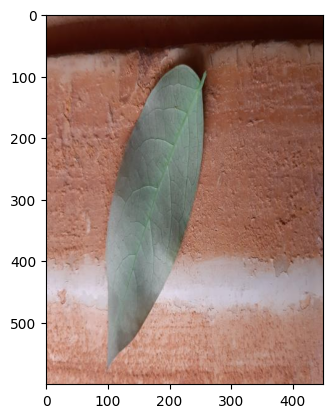

In [3]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '352.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (256, 256))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = loaded_model_imageNet.predict(x)
print((result*100).astype('int'))
print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)